## Predicting Rainfall in Vancouver

### Introduction

Being one of the rainiest cities in all of Canada, Vancouver averages over 1 metre of rainfall per year (Government of Canada 1981-2010 Climate Normals & Averages). Daily weather forecasts have become essential for residents, from planning what to wear to figuring out their activities for the following day, expressing a great appreciation for forecasts used by meteorologists. Meteorologists use complex computations based on Lewis Richardson's numerical process for weather prediction (1922). However, a [2021 study by Colorado State University](https://source.colostate.edu/ai-and-machine-learning-are-improving-weather-forecasts-but-they-wont-replace-human-experts/#:~:text=Some%20studies%20have%20shown%20that,computing%20power%20the%20models%20require.) showed that machine-learning-based forecast systems could predict the weather just as well, but at a fraction of the cost, lowering the amount of resources required. This further leads us to question if it is possible to predict how much it would rain on any given day of the year. 
This project aims to explore this through the use of meteorological measurements such as temperature, relative humidity, time of the year, and windspeed with a regression model to predict rainfall amounts. This model will be trained using a [dataset](https://vancouver.weatherstats.ca/download.html) downloaded from Vancouver Weather Stats, containing climate data for Vancouver for the past decade (2012-2022).

### Preliminary Data Analysis

Our first step is to load, wrangle, and explore the data visualizations. We start by loading the five below packages (`tidyverse`,`haven`,`lubridate`,`tidymodels`,`cowplot`) needed for our analysis.

In [1]:
## needed packages
library(tidyverse)
library(haven)
library(lubridate)
library(tidymodels)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   mask

From the website (https://vancouver.weatherstats.ca/download.html) we downloaded the data of the weather, which is a .csv file with headers. We’ll use the `read_csv` function to load the data.

In [2]:
weather <- read_csv("https://raw.githubusercontent.com/taimagher/Weather-Stats-Report/main/weatherstats_vancouver_daily.csv")

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 3951 Columns: 70
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (58): max_temperature, avg_hourly_temperature, avg_temperature, min_tem...
lgl   (9): solar_radiation, max_cloud_cover_4, avg_hourly_cloud_cover_4, avg...
date  (1): date
time  (2): sunrise, sunset

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Let us take a look at the first 6 rows of our data.

In [3]:
weather |> slice(1:6)

date,max_temperature,avg_hourly_temperature,avg_temperature,min_temperature,max_humidex,min_windchill,max_relative_humidity,avg_hourly_relative_humidity,avg_relative_humidity,⋯,avg_cloud_cover_4,min_cloud_cover_4,max_cloud_cover_8,avg_hourly_cloud_cover_8,avg_cloud_cover_8,min_cloud_cover_8,max_cloud_cover_10,avg_hourly_cloud_cover_10,avg_cloud_cover_10,min_cloud_cover_10
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>
2022-10-28,14.2,10.57,11.14,8.1,NA,NA,100,91.3,85.0,⋯,NA,NA,8,6.5,5.5,3,NA,NA,NA,NA
2022-10-27,12.2,10.51,10.25,8.3,NA,NA,100,97.8,93.0,⋯,NA,NA,8,8.0,7.5,7,NA,NA,NA,NA
2022-10-26,10.2,8.18,7.44,4.7,NA,NA,100,90.8,85.0,⋯,NA,NA,8,6.8,5.5,3,NA,NA,NA,NA
2022-10-25,10.2,8.86,8.80,7.4,NA,NA,100,97.5,93.5,⋯,NA,NA,8,8.0,7.5,7,NA,NA,NA,NA
2022-10-24,13.3,9.51,10.35,7.4,NA,NA,100,94.5,86.0,⋯,NA,NA,8,6.4,4.5,1,NA,NA,NA,NA
2022-10-23,11.9,8.70,7.60,3.3,NA,NA,100,89.3,83.0,⋯,NA,NA,8,6.9,4.5,1,NA,NA,NA,NA


We see that there are columns containing maximum and minimum readings recorded for each day. We do not need these columns, since it is not reasonable to train our model on extreme radings (they could contain outliers). We shall thus select only the columns `date`, those that start with `avg_*`, and `rain`.

We must also filter out rows with `NA` values for `rain`. Otherwise, our regression algorithm can unintentionally predict `NA` due to an `NA` value when calculating the mean value of nearest neighbors.

In [4]:
rain_data <- weather |>
                    select(date, starts_with('avg'), rain) |>
                    filter(is.na(rain) == FALSE)

Before we proceed, let us first split our data into training and testing to ensure fairness when testing accuracy. We have chosen to allocate 75% of the data for training. This ensures balance between enough data available a well-trained model, aswellas enough data to judge the accuracy well. We maintain evenness of the `rain` column's values when splitting. We also set a seed so that our split is reproducible when we move on to actually implementing the algorithm.

In [5]:
set.seed(78)

rain_split <- initial_split(rain_data, prop = 0.75, strata = rain)
rain_training <- training(rain_split)
rain_testing <- testing(rain_split)

total_rain_year <- rain_training |> 
                    group_by(year(date)) |>
                    filter(year(date) != 2022) |> # Since 2022 isn't over, it is unfair to use it in totalling
                    summarize(sum(rain))
colnames(total_rain_year) <- c("Year", "Total Rainfall (mm)")
total_rain_year

Year,Total Rainfall (mm)
<dbl>,<dbl>
2012,926.3
2013,749.2
2014,751.8
2015,804.8
2016,913.2
2017,931.9
2018,985.8
2019,742.1
2020,750.8


###### *Table 1: Rain Training model from years 2012-2021*


This table shows us how significant rainfall amounts in Vancouver are, and that they have been consistent over time. We will now move on to identifying predictors to choose for our model.

### Choosing Predictors

We know that rain changes seasonally. To confirm this, we plot a scatterplot (using _only_ training data) with the date on the _x_-axis and the rainfall in millimetres on the _y_-axis. 

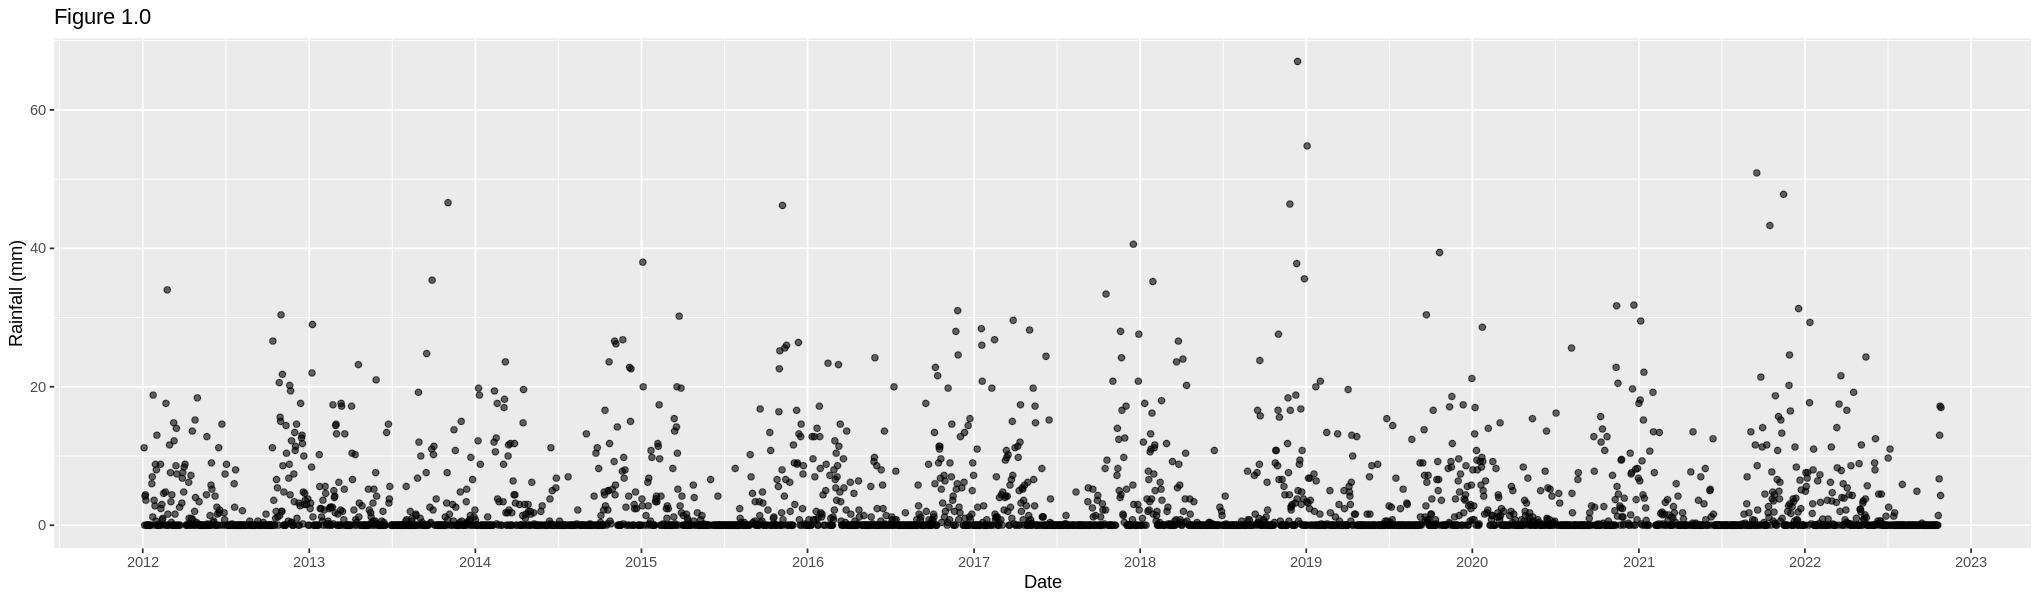

In [6]:
options(repr.plot.width = 17, repr.plot.height = 5)

rain_over_time_plot <- ggplot(rain_training, aes(x = date, y = rain)) + 
                        ggtitle("Figure 1.0")+
                        geom_point(alpha = 0.6) + 
                        labs(x = "Date", y = "Rainfall (mm)") +
                        scale_x_date(date_labels = "%Y", date_breaks = "1 year")
                     
rain_over_time_plot

We can confirm from the above plot that the rainfall does indeed follow a seasonal pattern, dropping around the middle of each calendar year. It is evident that the actual time in the year is useful when predicting rain. Let us add a new column called `yday`, which gives a value from 0 to 366 (based on day of the year) for each of our observations. For example, January 1st would have a `yday` of 1, February 3rd would have a `yday` of 34, etc. This will be useful as a predictor.

In [7]:
rain_training <- rain_training |> mutate(yday = yday(date))
rain_testing <- rain_testing |> mutate(yday = yday(date))

According to [The National Oceanic and Atmospheric Administration](https://www.noaa.gov/education/resource-collections/weather-atmosphere/weather-observations#:~:text=Temperature%2C%20humidity%2C%20precipitation%2C%20air,first%20weather%20observations%20were%20recorded), the ‘key observations’ used to predict weather patterns are temperature, humidity, wind speed, air pressure, and wind direction. 

Since wind direction is not quantifiable, we can't use it to train our _KNN_ regression model. We shall investigate how the other measurements affect rain. Let us summarize the mean value of these measurements for each day of the year.

In [8]:
rain_summary <- rain_training |>
                group_by(yday) |>
                summarize(rain = mean(rain), 
                          avg_temperature = mean(avg_temperature),
                          avg_relative_humidity = mean(avg_temperature),
                          avg_wind_speed = mean(avg_wind_speed),
                          avg_pressure_station = mean(avg_pressure_station))

Let us now visualize the relation between rainfall and our various potential predictors, as well as how they both correlate with the time of the year.


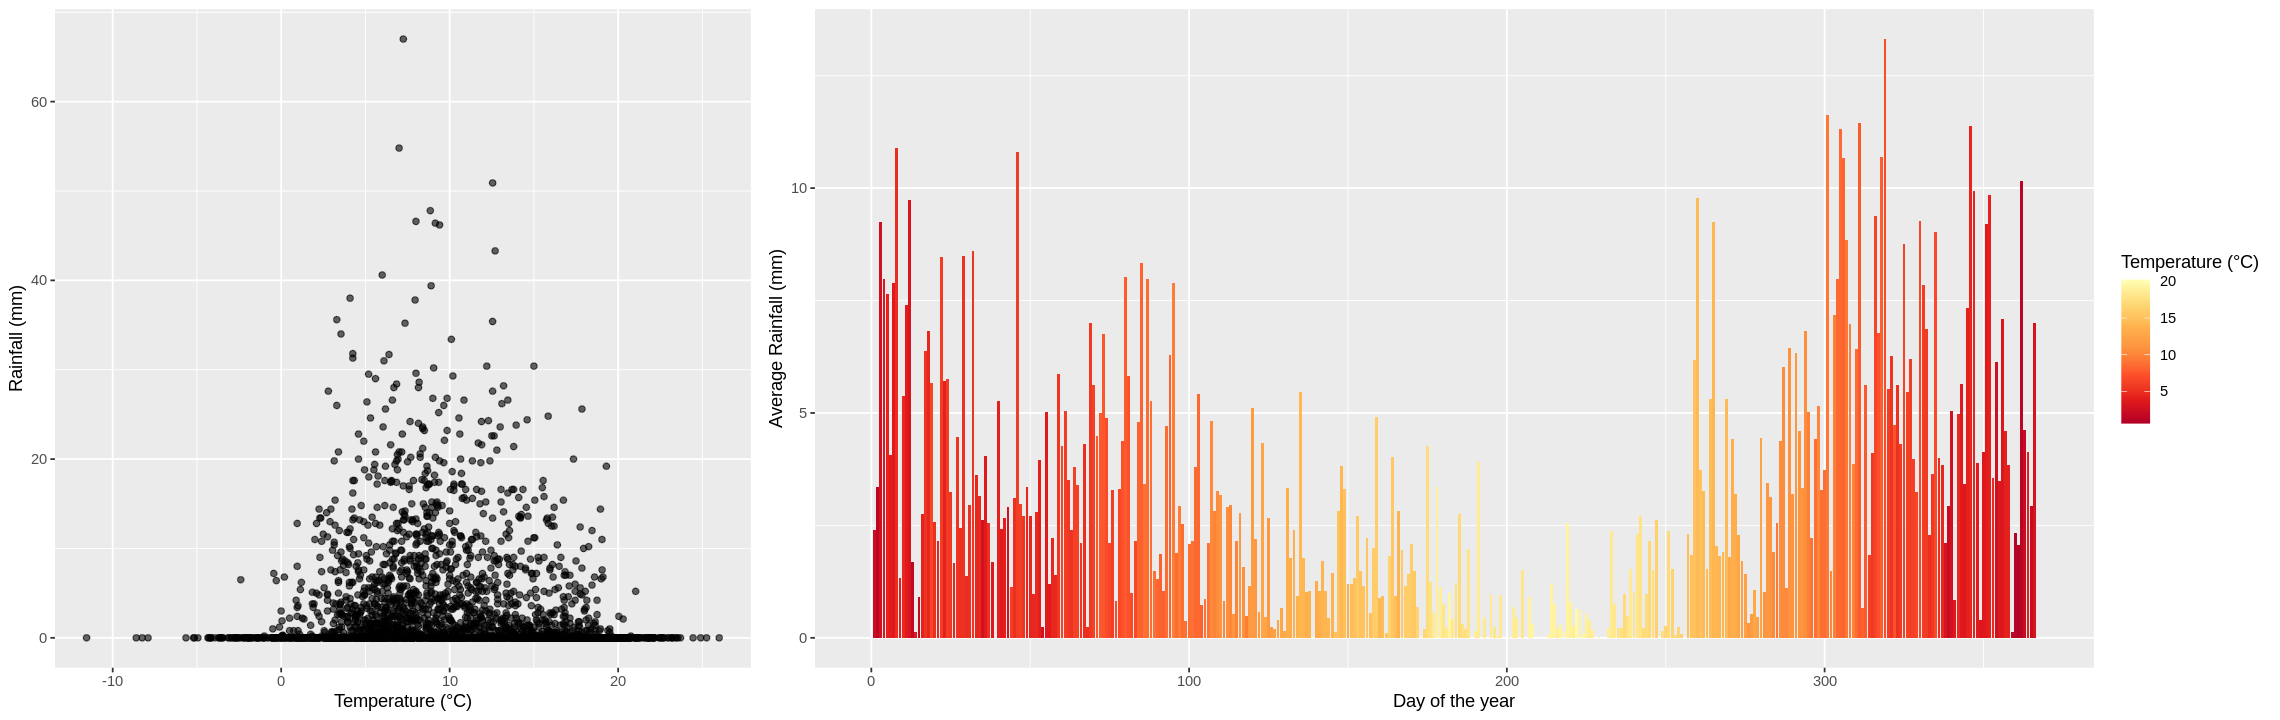

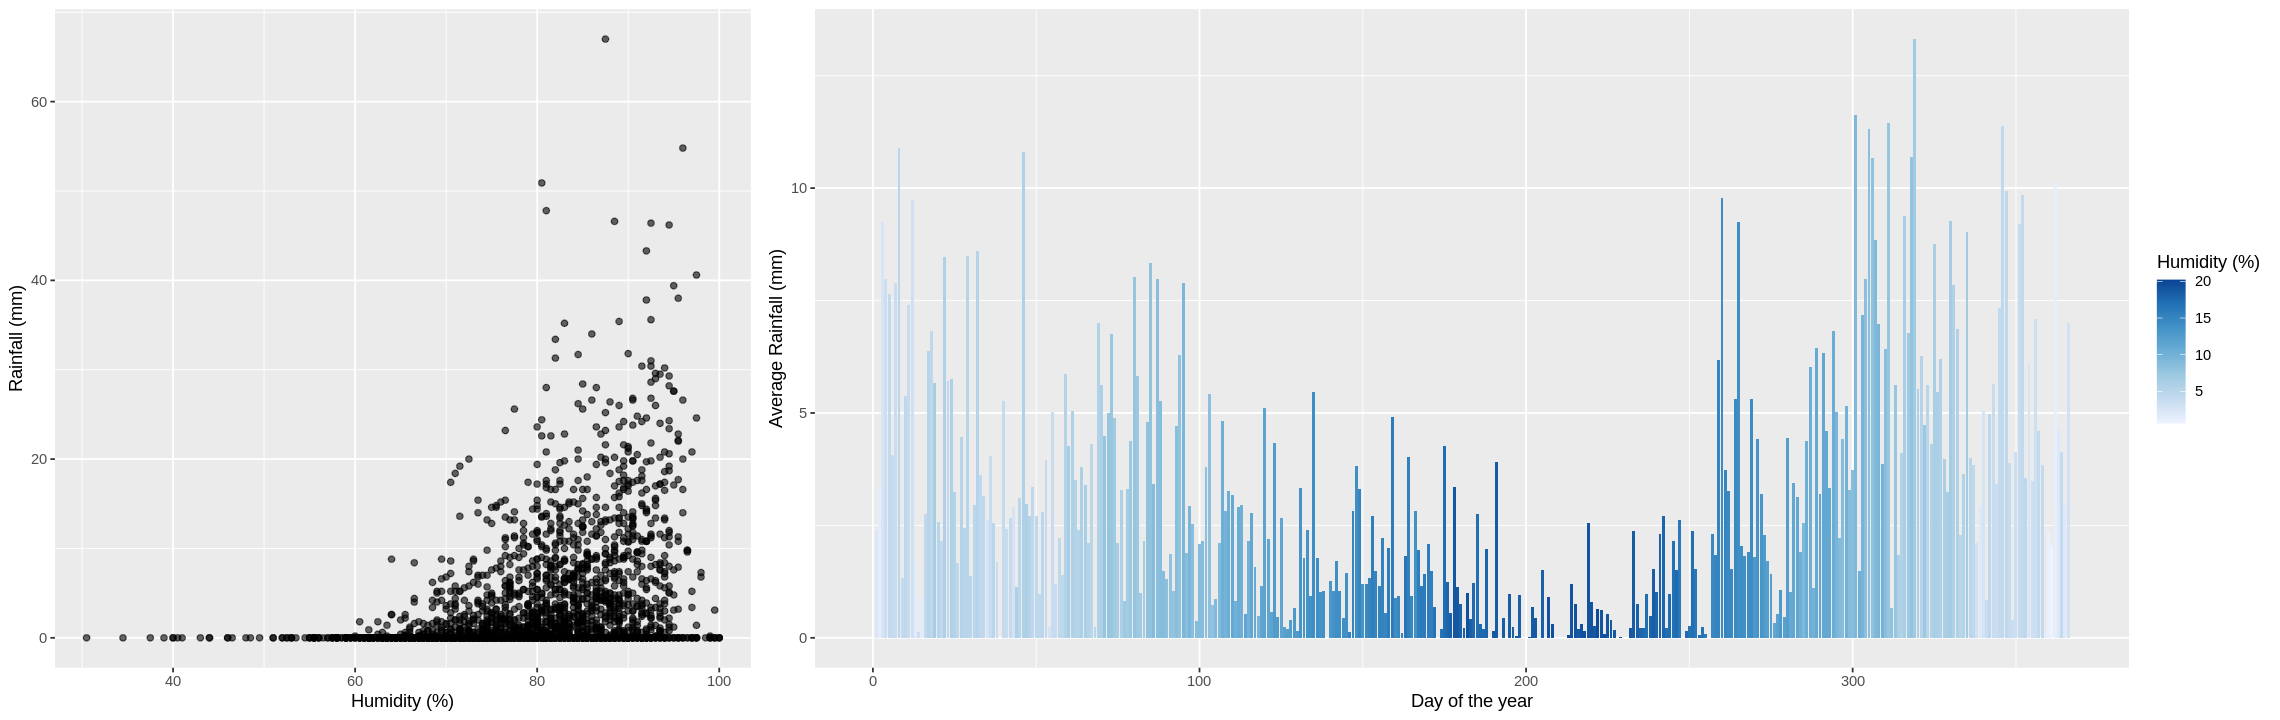

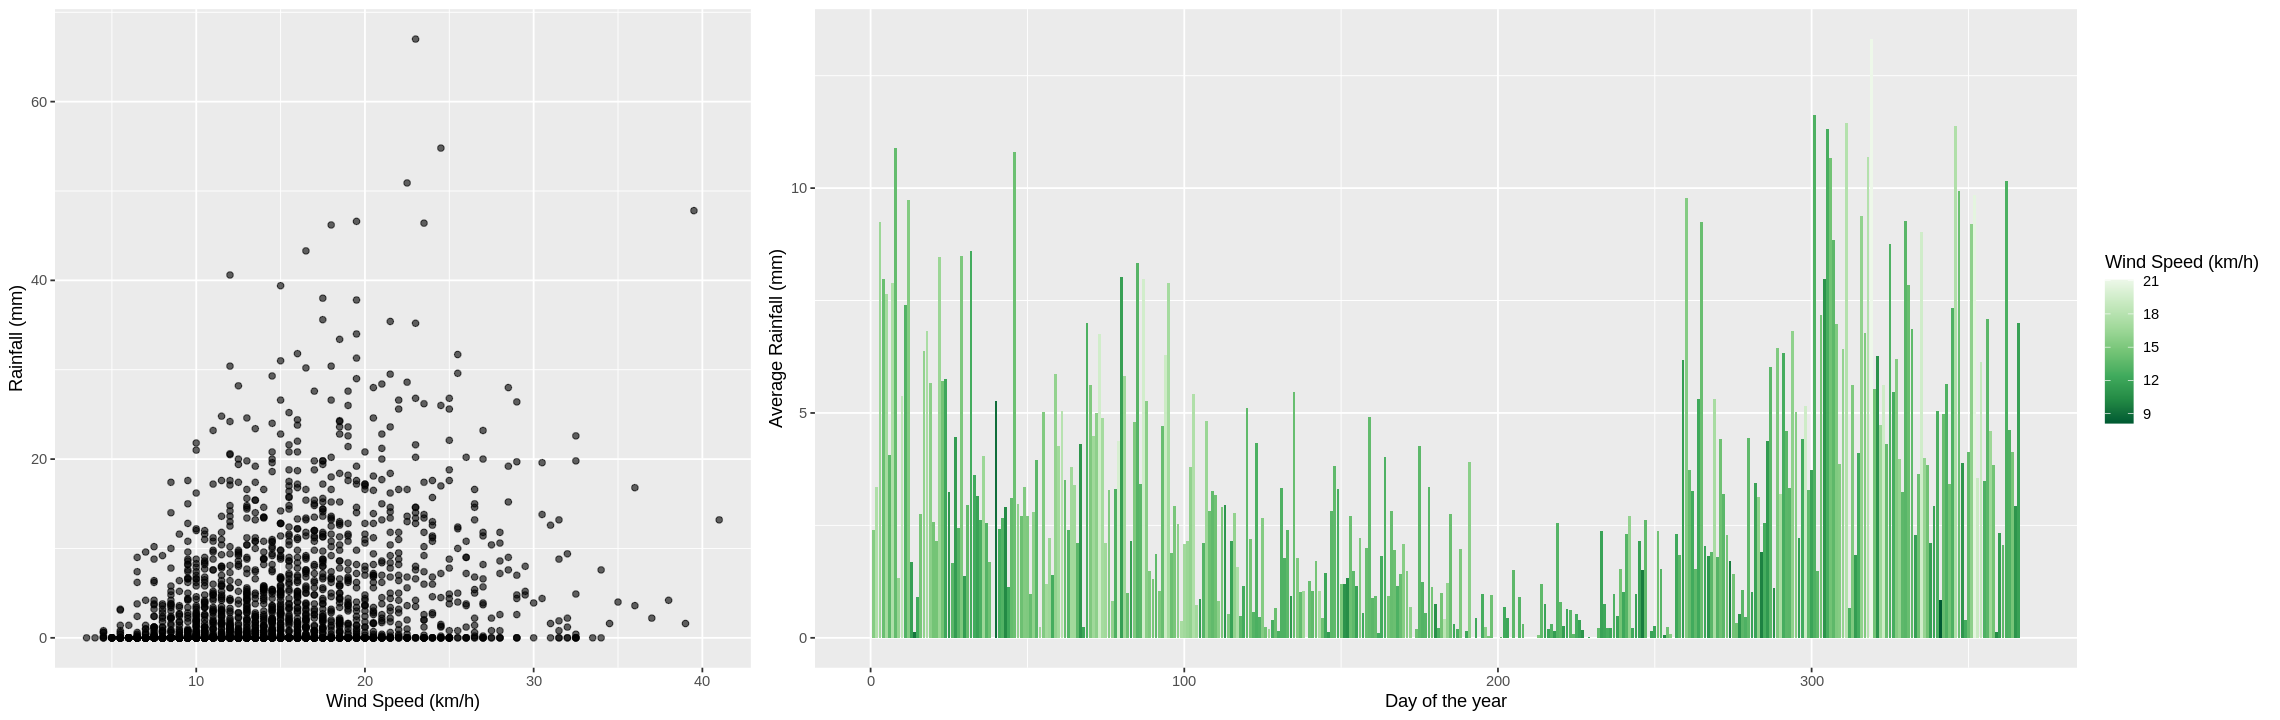

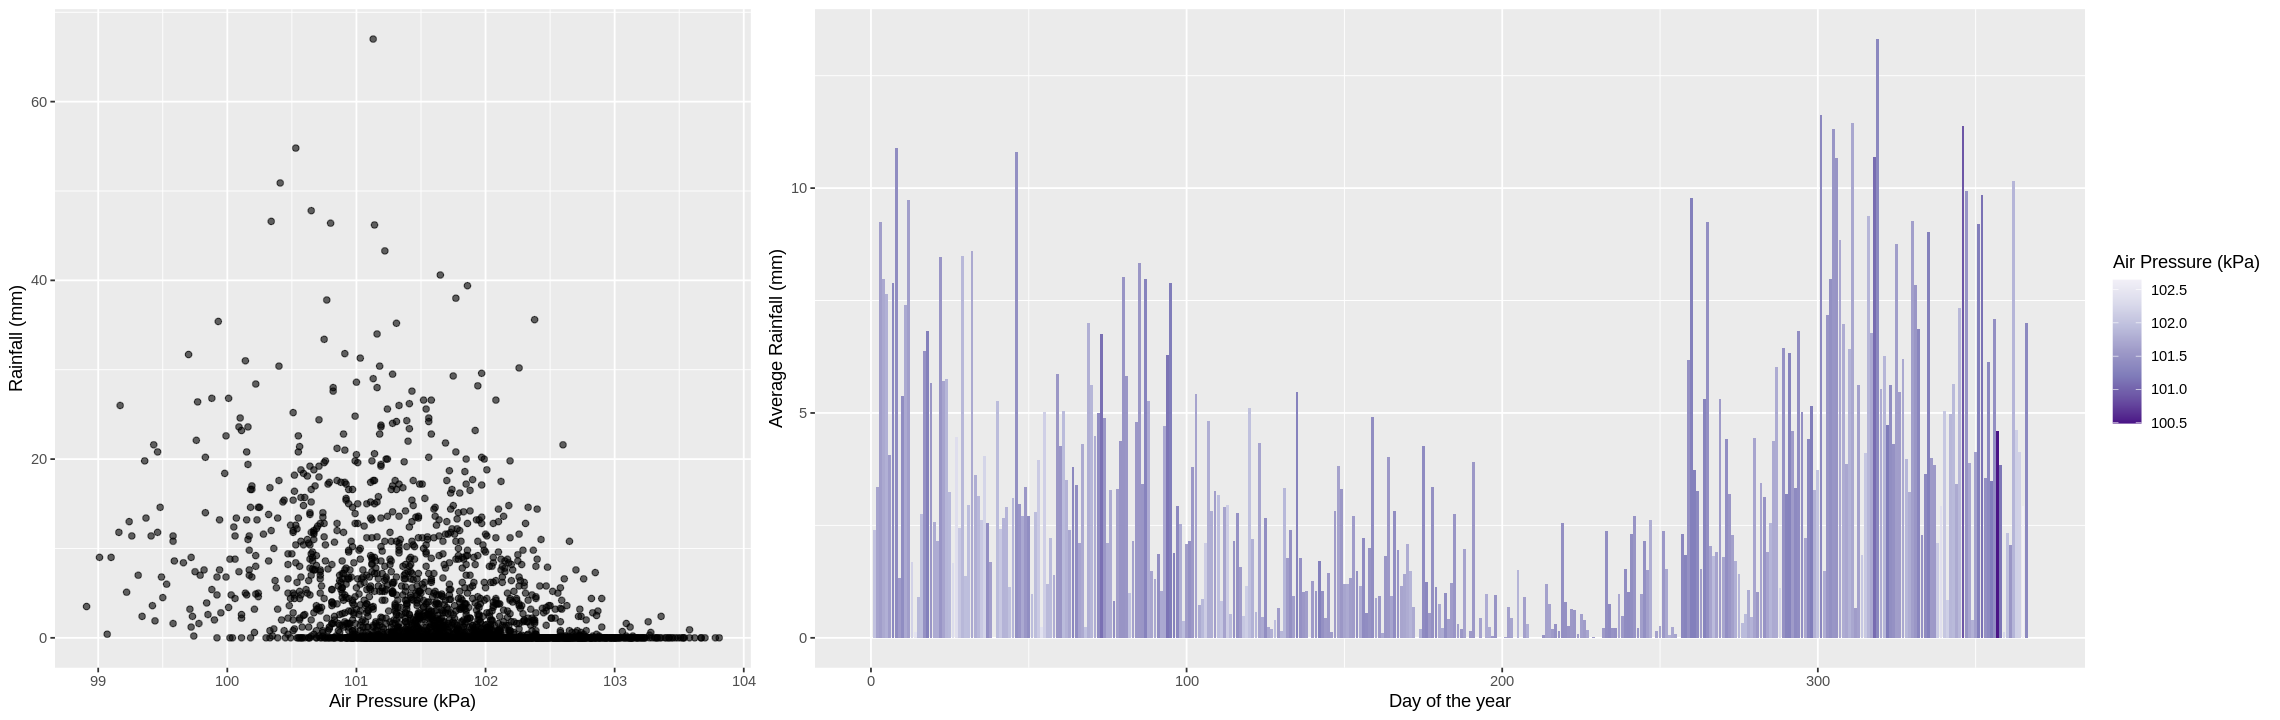

In [9]:
options(repr.plot.width = 19, repr.plot.height = 6)

rain_temperature_plot <- ggplot(rain_training, aes(x = avg_temperature, y = rain)) + 
                         geom_point(alpha= 0.6) + 
                         labs(x = "Temperature (°C)", y = "Rainfall (mm)")

rain_humidity_plot <- ggplot(rain_training, aes(x = avg_relative_humidity, y = rain)) +
                      geom_point(alpha= 0.6) +
                      labs(x = "Humidity (%)", y = "Rainfall (mm)")

rain_windspeed_plot <- ggplot(rain_training, aes(x = avg_wind_speed, y = rain)) + 
                       geom_point(alpha= 0.6) + 
                       labs(x = "Wind Speed (km/h)", y = "Rainfall (mm)")

rain_pressure_plot <- ggplot(rain_training, aes(x = avg_pressure_station, y = rain)) + 
                       geom_point(alpha= 0.6) + 
                       labs(x = "Air Pressure (kPa)", y = "Rainfall (mm)")

rain_temperature_over_time_plot <- rain_summary |> ggplot(aes(x = yday, y = rain)) + 
                                   geom_bar(stat = 'identity', aes(fill = avg_temperature)) + 
                                   scale_fill_distiller(palette = 'YlOrRd') +
                                   labs(x = "Day of the year", y = "Average Rainfall (mm)", fill = "Temperature (°C)")
rain_humidity_over_time_plot <- rain_summary |> ggplot(aes(x = yday, y = rain)) + 
                                geom_bar(stat = 'identity', aes(fill = avg_relative_humidity)) + 
                                scale_fill_distiller(palette = 'Blues', direction = 1) +
                                labs(x = "Day of the year", y = "Average Rainfall (mm)", fill = "Humidity (%)")
rain_windspeed_over_time_plot <- rain_summary |> ggplot(aes(x = yday, y = rain)) + 
                            geom_bar(stat = 'identity', aes(fill = avg_wind_speed)) +
                            scale_fill_distiller(palette = 'Greens') +
                            labs(x = "Day of the year", y = "Average Rainfall (mm)", fill = "Wind Speed (km/h)")

rain_pressure_over_time_plot <- rain_summary |> ggplot(aes(x = yday, y = rain)) + 
                            geom_bar(stat = 'identity', aes(fill = avg_pressure_station)) +
                            scale_fill_distiller(palette = 'Purples') +
                            labs(x = "Day of the year", y = "Average Rainfall (mm)", fill = "Air Pressure (kPa)")

rain_temperature <- plot_grid(p1 = rain_temperature_plot, p2 = rain_temperature_over_time_plot, rel_widths = c(1, 2))
rain_temperature
rain_humidity <- plot_grid(p1 = rain_humidity_plot, p2 = rain_humidity_over_time_plot, rel_widths = c(1, 2))
rain_humidity
rain_wind <- plot_grid(p1 = rain_windspeed_plot, p2 = rain_windspeed_over_time_plot, rel_widths = c(1, 2))
rain_wind
rain_pressure <- plot_grid(p1 = rain_pressure_plot, p2 = rain_pressure_over_time_plot, rel_widths = c(1, 2))
rain_pressure

It is visible that all these values have relationships with rainfall, and their change with time is visible too. We now have a good set of predictors for our regression model: `yday + avg_temperature + avg_relative_humidity + avg_wind_speed + avg_pressure_station`. These are the day of the year, and the measurementd for temperature, relative humidity, wind speed, and pressure.

### Prediction using _KNN_

We will be predicting the amount of rainfall in millimetres using the $K$-Nearest Neighbors algorithm.  We have already split our data into a training and a testing set. We must then scale and center our predictors' values to ensure each predictor has an equal weighting on the prediction. To pick a value of $k$, we will use a 10-fold cross validation process and compare the root mean squared error for various values of $k$. We chose to use 10 folds because it is a reasonable balance between the $RMSE$ values we get and the amount of time we have to carry out our project.

Once we train our model using our chosen $k$ value, we will use it to predict the rainfall values using the predictor variables in our _testing_ dataset. We will compare our predictions to the actual values to obtain the root mean squared predicted error ($RMSPE$) of our model. We will visualize our results using a line graph of _predicted_ values, layered on a scatterplot of the actual rainfall values against the day of the year. We can also produce further such plots for each of our predictor variables, to get a better understanding of where our model performed well and where it didn't.

### Expected Outcomes and Significance


The outcome we aim to achieve is an accurate regression model for predicting the rainfall amount for any given day of the year. 
This exploration could potentially also shed light on the effects of Climate Change in Vancouver, following events such as 2021 [atmospheric river](https://www.uvic.ca/news/topics/2022+bc-floods-and-climate-change+news#:~:text=The%20powerful%20atmospheric%20river%20that,disaster%20in%20the%20province's%20history.) that caused severe flooding in many parts of the coast. If we notice our model begins to be _more inaccurate_ in the coming years, this could further prove this impact of climate change. 
If our model is accurate, it could be a step in replacing the expensive numerical methods of weather forecasting used today, saving on computing power, and indirectly, fossil fuel usage.


In [10]:
rain_recipe <- recipe(rain ~ yday + avg_temperature + avg_relative_humidity + avg_wind_speed + avg_pressure_station,
                      data = rain_training) |>
                step_center(all_predictors()) |>
                step_scale(all_predictors())

rain_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
                set_engine("kknn") |>
                set_mode("regression") 

rain_vfold <- vfold_cv(rain_training, v = 10, strata = rain)

gridvals <- tibble(neighbors = seq(1, 100))

rain_results <- workflow() |> 
    add_recipe(rain_recipe) |> 
    add_model(rain_spec) |>
    tune_grid(resamples = rain_vfold, grid = gridvals) |> 
    collect_metrics()

In [11]:
rain_results <- rain_results |> filter(.metric == "rmse")
rain_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,6.449434,10,0.1928986,Preprocessor1_Model001
2,rmse,standard,5.619342,10,0.1616362,Preprocessor1_Model002
3,rmse,standard,5.299381,10,0.1726942,Preprocessor1_Model003
4,rmse,standard,5.110148,10,0.1663147,Preprocessor1_Model004
5,rmse,standard,5.004972,10,0.1628568,Preprocessor1_Model005
6,rmse,standard,4.906887,10,0.1769408,Preprocessor1_Model006
7,rmse,standard,4.846896,10,0.1773908,Preprocessor1_Model007
8,rmse,standard,4.823617,10,0.1767789,Preprocessor1_Model008
9,rmse,standard,4.776859,10,0.1673040,Preprocessor1_Model009


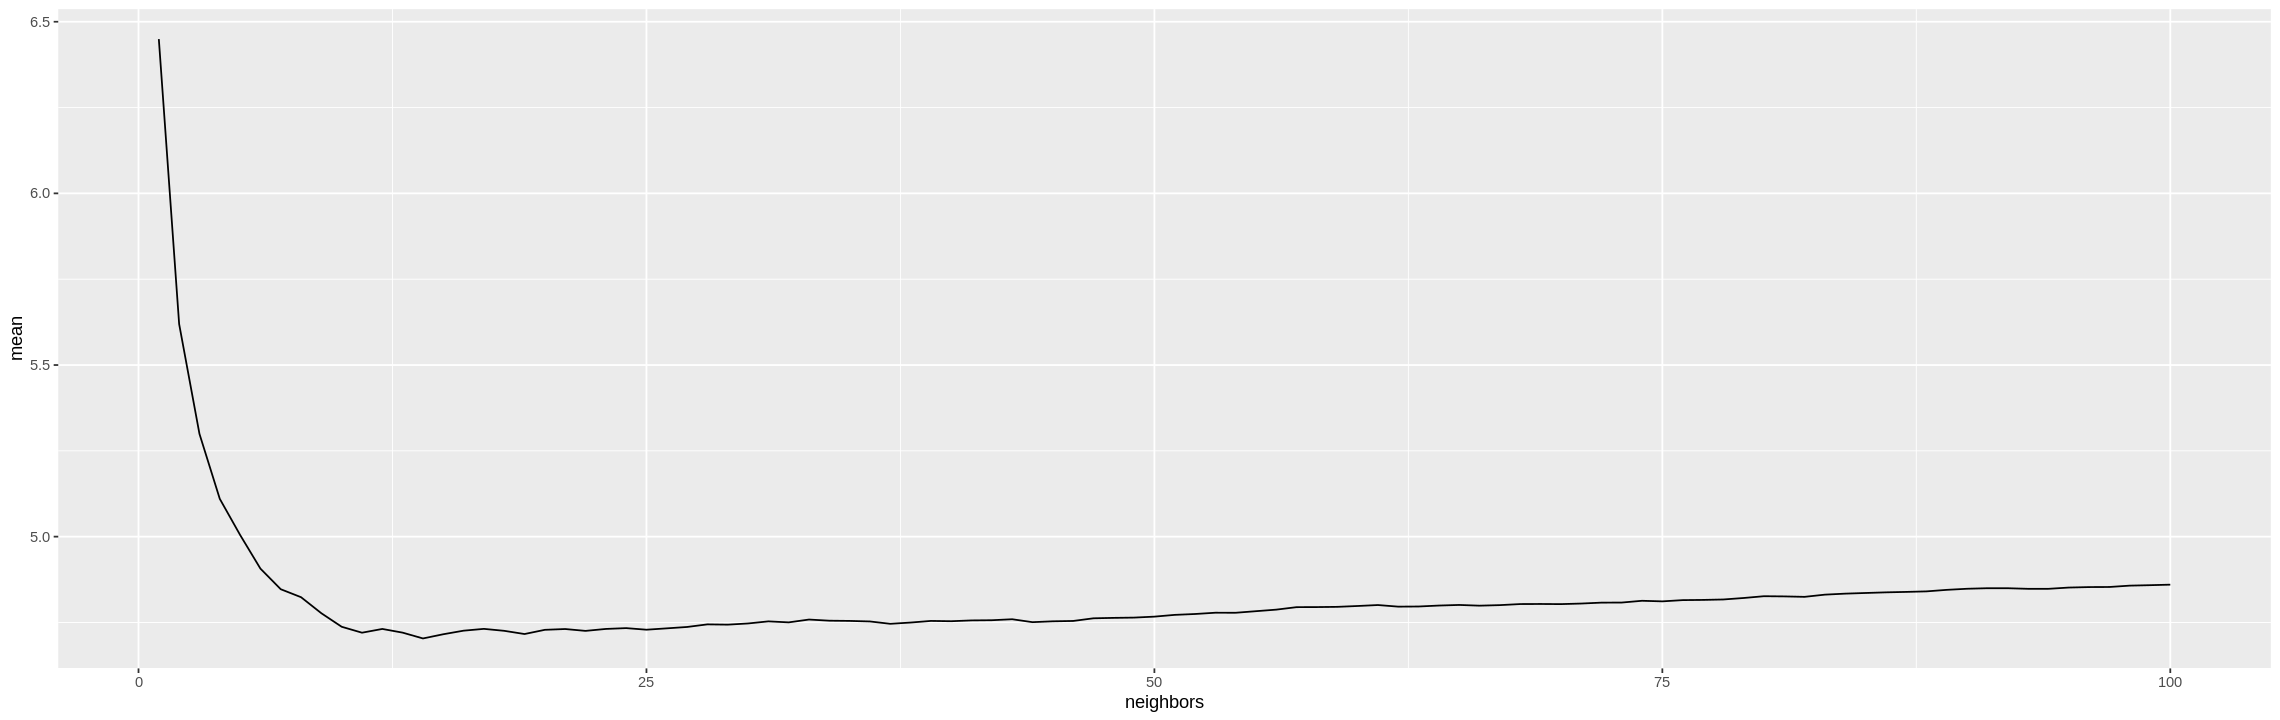

In [12]:
rain_results_plot <- ggplot(rain_results, aes(x = neighbors, y = mean)) +
                        geom_line()
rain_results_plot

We can see that there don't appear to be any lucky spikes, so we shall take the value of k that gave the minimum $RMSPE$.

In [13]:
k_min <- rain_results |>
            arrange(mean) |>
            head(1) |>
            select(neighbors) |>
            pull()
k_min

[1] 14

In [14]:
rain_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

rain_best_fit <- workflow() |>
         add_recipe(rain_recipe) |>
         add_model(rain_best_spec) |>
         fit(data = rain_training)

rain_pred <- rain_best_fit |>
          predict(rain_testing) |>
          bind_cols(rain_testing)
          

rain_summary <- rain_pred |>
                metrics(truth = rain, estimate = .pred)

rain_summary


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.8935777
rsq,standard,0.4466034
mae,standard,2.6283231


**TODO** <br />
We can see that our $RMSPE$ value is ~4.89 mm of rainfall. This is ________. However, ________.

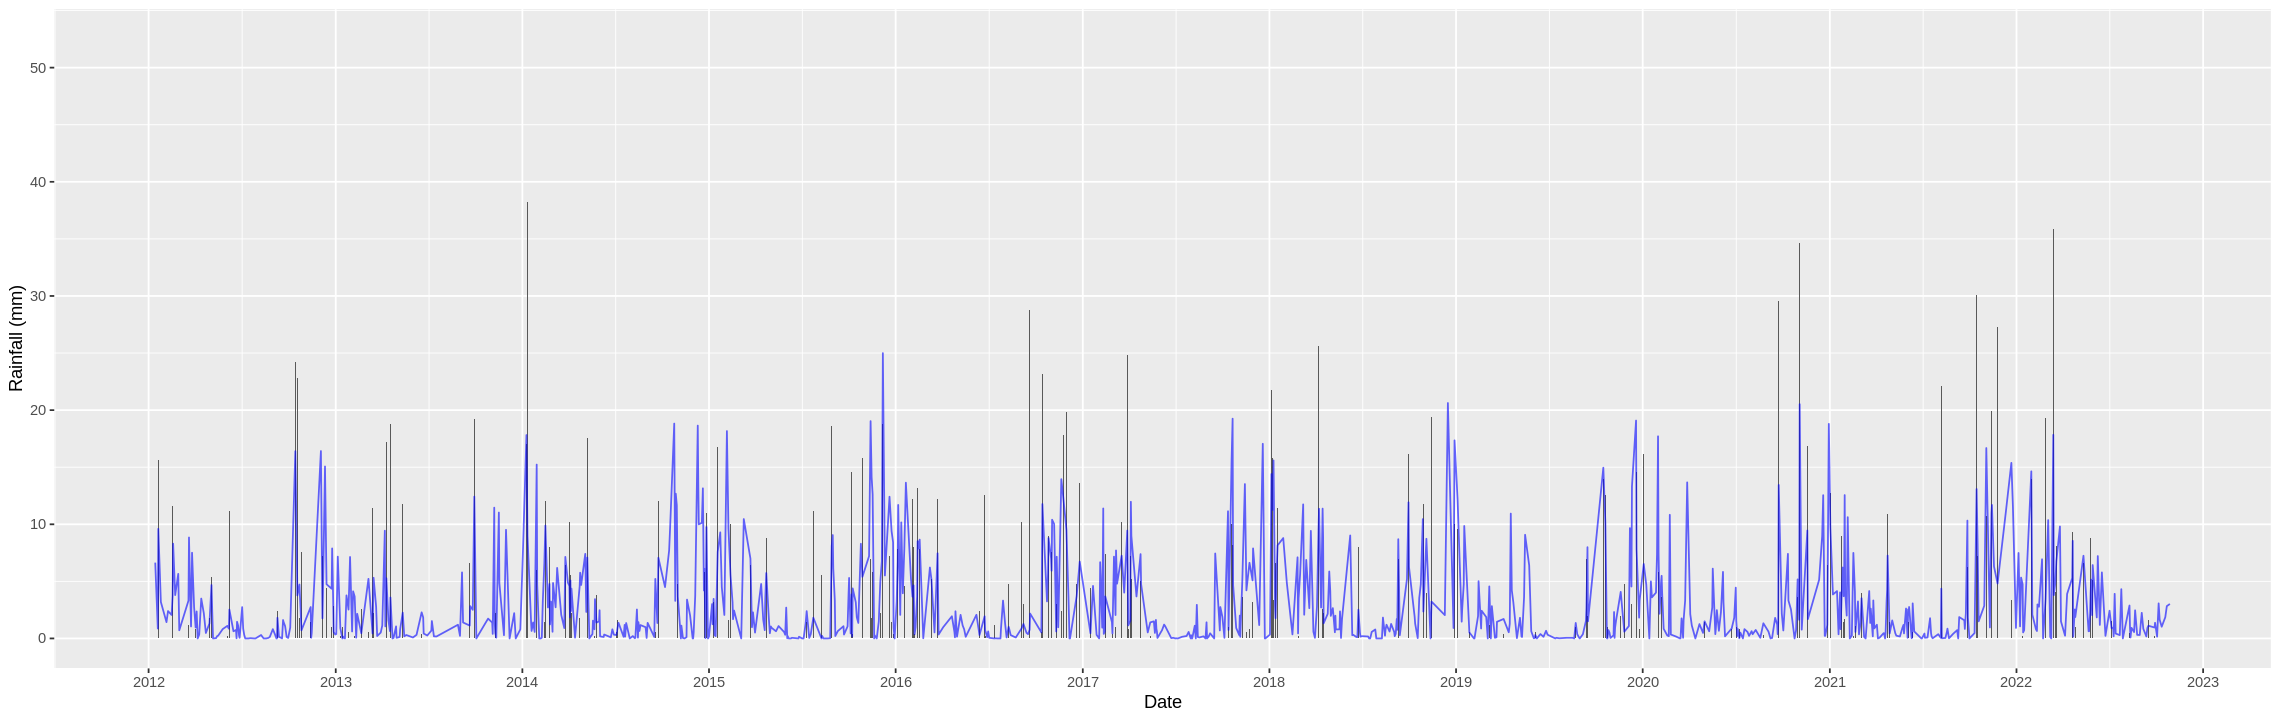

In [15]:
rain_pred_plot <- ggplot(rain_pred, aes(x = date, y = rain)) + 
                        geom_bar(stat = "identity") +
                        geom_line(data = rain_pred, aes(x = date, y = .pred), color = "blue", alpha = 0.6) +
                        labs(x = "Date", y = "Rainfall (mm)") +
                        scale_x_date(date_labels = "%Y", date_breaks = "1 year")
rain_pred_plot

   ## Works Cited 

Hill, Russ Schumacher and Aaron. “AI and Machine Learning Are Improving Weather Forecasts, but They Won’t Replace Human Experts.” Colarado State University, 26 May 2022, source.colostate.edu/ai-and-machine-learning-are-improving-weather-forecasts-but-they-wont-replace-human-experts/#:~:text=Some%20studies%20have%20shown%20that.

National Oceanic and Atmospheric Administration. “Weather Observations.” NOAA, 1 Feb. 2011, www.noaa.gov/education/resource-collections/weather-atmosphere/weather-observations#:~:text=Temperature%2C%20humidity%2C%20precipitation%2C%20air.

testtt

## Conclusion
